<a href="https://colab.research.google.com/github/Ayakata/Coursera_HTML_CSS_JS/blob/master/trans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.1.0
!pip install Keras==2.3.1

     |████████████████████████████████| 421.8MB 30kB/s 
     |████████████████████████████████| 450kB 41.5MB/s 
     |████████████████████████████████| 3.9MB 53.7MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=b61669f1024aa643db8ccb0b42ae56bb842fc069748af6d29667c3da66e0db56
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully 

In [2]:
try:
  from google.colab import drive
  import os
  drive.mount('/content/drive')
  os.makedirs(data_dir, exist_ok=True)
except ImportError:
  data_dir = '.'

Mounted at /content/drive


In [3]:
import os
import time
import numpy as np
import tensorflow as tf
from skimage.io import imread

from keras.backend.tensorflow_backend import set_session

from keras.models import Model

np.random.seed(42)
tf.random.set_seed(42)

Using TensorFlow backend.


In [4]:
from keras.layers import Input
from keras.applications import xception
from keras.preprocessing import image
from keras.utils import to_categorical

In [8]:
!cp -r '/content/drive/My Drive/image_dataset' '/content/sample_data'

In [133]:
IMGS = np.zeros((400, 150, 150, 3), dtype='uint8')

for i, im in enumerate(next(os.walk('/content/sample_data/image_dataset/seg_test/buildings'))[2]):
  img = imread('/content/sample_data/image_dataset/seg_test/buildings/' + im)
  try:
    IMGS[i] = img
  except IndexError:
    break

In [52]:
train_data_dir = '/content/sample_data/image_dataset/seg_train'
test_data_dir = '/content/sample_data/image_dataset/seg_test'
validation_data_dir = '/content/sample_data/image_dataset/seg_val'

img_height = 150
img_width = 150

batch_size = 16
epochs = 10

labels = []
accur = []
spd = []

train_building_class = len(next(os.walk(train_data_dir + '/buildings'))[2])
train_forest_class = len(next(os.walk(train_data_dir + '/forest'))[2])
train_glacier_class = len(next(os.walk(train_data_dir + '/glacier'))[2])
train_mountain_class = len(next(os.walk(train_data_dir + '/mountain'))[2])
train_sea_class = len(next(os.walk(train_data_dir + '/sea'))[2])
train_street_class = len(next(os.walk(train_data_dir + '/street'))[2])

nb_train_samples = np.sum([train_building_class,
                           train_forest_class,
                           train_glacier_class,
                           train_mountain_class,
                           train_sea_class,
                           train_street_class])

nb_validation_samples = 200 * 6

In [53]:
input_tensor = Input(shape=(img_height,img_width,3))

base_model = xception.Xception(weights='imagenet',
                          include_top=False,
                          input_shape=(img_width, img_height, 3),
                          pooling='avg')

data_generator = image.ImageDataGenerator(rescale=1. / 255)

train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

bottleneck_features_train = base_model.predict_generator(
        train_generator, 
        nb_train_samples // batch_size,
        verbose=1)

print('Prediction of the training set finished.')

np.save(open('bottleneck_features_train_xception.npy', 'wb'),
            bottleneck_features_train)

validation_generator = data_generator.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

bottleneck_features_validation = base_model.predict_generator(
        validation_generator, 
        nb_validation_samples // batch_size)

print('Prediction of the validation set finished.')

np.save(open('bottleneck_features_validation_xception.npy', 'wb'),
            bottleneck_features_validation)

Found 12832 images belonging to 6 classes.
802/802 [==============================] - 41s 51ms/step
Prediction of the training set finished.
Found 1200 images belonging to 6 classes.
Prediction of the validation set finished.


In [54]:
train_data = np.load(open('bottleneck_features_train_xception.npy', 'rb'))
train_labels = np.array(([0] * train_building_class) + ([1] * train_forest_class) + ([2] * train_glacier_class) + ([3] * train_mountain_class) + ([4] * train_sea_class) + ([5] * train_street_class))
train_labels = to_categorical(train_labels)

validation_data = np.load(open('bottleneck_features_validation_xception.npy', 'rb'))
validation_labels = np.array([0] * (200) + [1] * (200) + [2] * (200) + [3] * (200) + [4] * (200) + [5] * (200))
validation_labels = to_categorical(validation_labels)

In [55]:
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD
from keras.layers import Dropout, Dense

model = Sequential()
    
model.add(Dense(256, activation='relu', input_shape=base_model.output_shape[1:]))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))    

model.add(Dense(6, activation='softmax'))

model.compile(optimizer=SGD(lr=0.005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='top-weights-xception.hdf5', verbose=1, save_best_only=True)

history = model.fit(train_data,
                    train_labels,
                    epochs=10,
                    batch_size=batch_size,
                    callbacks=[checkpointer],
                    validation_data=(validation_data, validation_labels))

Train on 12832 samples, validate on 1200 samples
Epoch 1/10
12832/12832 [==============================] - 2s 193us/step - loss: 0.8401 - accuracy: 0.6917 - val_loss: 0.3707 - val_accuracy: 0.8783

Epoch 00001: val_loss improved from inf to 0.37072, saving model to top-weights-xception.hdf5
Epoch 2/10
12832/12832 [==============================] - 3s 204us/step - loss: 0.4712 - accuracy: 0.8325 - val_loss: 0.3236 - val_accuracy: 0.8875

Epoch 00002: val_loss improved from 0.37072 to 0.32363, saving model to top-weights-xception.hdf5
Epoch 3/10
12832/12832 [==============================] - 3s 197us/step - loss: 0.4052 - accuracy: 0.8583 - val_loss: 0.3123 - val_accuracy: 0.8883

Epoch 00003: val_loss improved from 0.32363 to 0.31232, saving model to top-weights-xception.hdf5
Epoch 4/10
12832/12832 [==============================] - 2s 176us/step - loss: 0.3712 - accuracy: 0.8678 - val_loss: 0.2891 - val_accuracy: 0.8967

Epoch 00004: val_loss improved from 0.31232 to 0.28915, saving mo

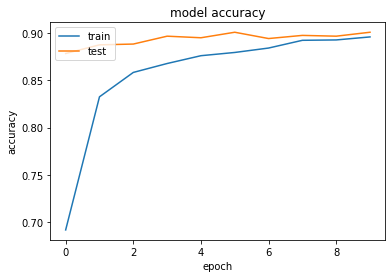

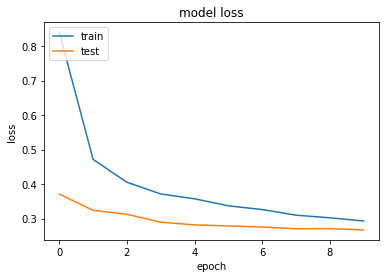

In [56]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [57]:
batch_size = 8
epochs = 5

input_tensor = Input(shape=(img_height,img_width,3))

base_model = xception.Xception(weights='imagenet',
                                            include_top=False,
                                            input_shape=(img_width, img_height, 3),
                                            pooling='avg')

top_model = Sequential()
    
top_model.add(Dense(256, activation='relu', input_shape=base_model.output_shape[1:]))
top_model.add(Dropout(0.5))

top_model.add(Dense(128, activation='relu'))
top_model.add(Dropout(0.5))    

top_model.add(Dense(6, activation='softmax'))

top_model.load_weights('top-weights-xception.hdf5')

model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

model.compile(optimizer=SGD(lr=0.005, momentum=0.1, nesterov=True),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


checkpointer = ModelCheckpoint(filepath='top-weights-xception.hdf5', verbose=1, save_best_only=True)

train_datagen = image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')

history = model.fit_generator(train_generator,
                            steps_per_epoch=nb_train_samples // batch_size,
                            epochs=epochs,
                            validation_data=validation_generator,
                            validation_steps=nb_validation_samples // batch_size)

Found 12832 images belonging to 6 classes.
Found 1200 images belonging to 6 classes.
Epoch 1/5
1604/1604 [==============================] - 235s 146ms/step - loss: 0.5827 - accuracy: 0.7986 - val_loss: 0.8047 - val_accuracy: 0.9142
Epoch 2/5
1604/1604 [==============================] - 225s 140ms/step - loss: 0.4032 - accuracy: 0.8672 - val_loss: 0.4228 - val_accuracy: 0.9175
Epoch 3/5
1604/1604 [==============================] - 226s 141ms/step - loss: 0.3271 - accuracy: 0.8933 - val_loss: 0.3138 - val_accuracy: 0.9167
Epoch 4/5
1604/1604 [==============================] - 224s 140ms/step - loss: 0.2900 - accuracy: 0.9041 - val_loss: 0.0176 - val_accuracy: 0.9317
Epoch 5/5
1604/1604 [==============================] - 224s 140ms/step - loss: 0.2538 - accuracy: 0.9161 - val_loss: 0.0094 - val_accuracy: 0.9258


In [58]:
test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

score = model.evaluate_generator(test_generator, batch_size)

print("Loss: ", score[0], "Accuracy: ", score[1])
accur.append(score[1])

Found 3000 images belonging to 6 classes.
Loss:  0.32907718420028687 Accuracy:  0.953125


In [140]:
start_time = time.time()
model.predict(IMGS)
spd.append(400 / (time.time() - start_time))
print("--- %s seconds ---" % (time.time() - start_time))
labels.append('xception')

--- 1.1555354595184326 seconds ---


'104.49768328666687'

In [59]:
from keras.applications import densenet

In [60]:
batch_size = 16

input_tensor = Input(shape=(img_height,img_width,3))

base_model = densenet.DenseNet121(weights='imagenet',
                          include_top=False,
                          input_shape=(img_width, img_height, 3),
                          pooling='avg')

data_generator = image.ImageDataGenerator(rescale=1. / 255)

train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

bottleneck_features_train = base_model.predict_generator(
        train_generator, 
        nb_train_samples // batch_size)

print('Prediction of the training set finished.')

np.save(open('bottleneck_features_train_dense.npy', 'wb'),
            bottleneck_features_train)

validation_generator = data_generator.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

bottleneck_features_validation = base_model.predict_generator(
        validation_generator, 
        nb_validation_samples // batch_size)

print('Prediction of the validation set finished.')

np.save(open('bottleneck_features_validation_dense.npy', 'wb'),
            bottleneck_features_validation)

Found 12832 images belonging to 6 classes.
Prediction of the training set finished.
Found 1200 images belonging to 6 classes.
Prediction of the validation set finished.


In [61]:
train_data = np.load(open('bottleneck_features_train_dense.npy', 'rb'))
validation_data = np.load(open('bottleneck_features_validation_dense.npy', 'rb'))

In [62]:
model = Sequential()
    
model.add(Dense(256, activation='relu', input_shape=base_model.output_shape[1:]))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))    

model.add(Dense(6, activation='softmax'))

model.compile(optimizer=SGD(lr=0.005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='top-weights-denseNet.hdf5', verbose=1, save_best_only=True)

history_dense = model.fit(train_data,
                    train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[checkpointer],
                    validation_data=(validation_data, validation_labels))

Train on 12832 samples, validate on 1200 samples
Epoch 1/5
12832/12832 [==============================] - 3s 205us/step - loss: 0.7956 - accuracy: 0.7021 - val_loss: 0.3583 - val_accuracy: 0.8600

Epoch 00001: val_loss improved from inf to 0.35831, saving model to top-weights-denseNet.hdf5
Epoch 2/5
12832/12832 [==============================] - 2s 176us/step - loss: 0.4780 - accuracy: 0.8254 - val_loss: 0.3308 - val_accuracy: 0.8683

Epoch 00002: val_loss improved from 0.35831 to 0.33082, saving model to top-weights-denseNet.hdf5
Epoch 3/5
12832/12832 [==============================] - 2s 171us/step - loss: 0.4187 - accuracy: 0.8494 - val_loss: 0.3081 - val_accuracy: 0.8900

Epoch 00003: val_loss improved from 0.33082 to 0.30815, saving model to top-weights-denseNet.hdf5
Epoch 4/5
12832/12832 [==============================] - 2s 186us/step - loss: 0.3790 - accuracy: 0.8656 - val_loss: 0.2992 - val_accuracy: 0.8900

Epoch 00004: val_loss improved from 0.30815 to 0.29923, saving model 

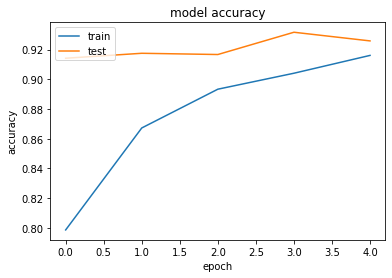

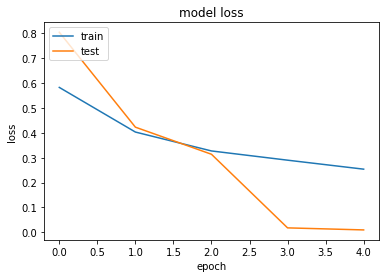

In [63]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [64]:
batch_size = 8
epochs = 5

input_tensor = Input(shape=(img_height,img_width,3))

base_model = densenet.DenseNet121(weights='imagenet',
                          include_top=False,
                          input_shape=(img_width, img_height, 3),
                          pooling='avg')

top_model = Sequential()
    
top_model.add(Dense(256, activation='relu', input_shape=base_model.output_shape[1:]))
top_model.add(Dropout(0.5))

top_model.add(Dense(128, activation='relu'))
top_model.add(Dropout(0.5))    

top_model.add(Dense(6, activation='softmax'))

top_model.load_weights('top-weights-denseNet.hdf5')

model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

model.compile(optimizer=SGD(lr=0.005, momentum=0.1, nesterov=True),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


checkpointer = ModelCheckpoint(filepath='top-weights-denseNet.hdf5', verbose=1, save_best_only=True)

train_datagen = image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')

history = model.fit_generator(train_generator,
                            steps_per_epoch=nb_train_samples // batch_size,
                            epochs=epochs,
                            validation_data=validation_generator,
                            validation_steps=nb_validation_samples // batch_size)

Found 12832 images belonging to 6 classes.
Found 1200 images belonging to 6 classes.
Epoch 1/5
1604/1604 [==============================] - 361s 225ms/step - loss: 0.6384 - accuracy: 0.7812 - val_loss: 0.2270 - val_accuracy: 0.9217
Epoch 2/5
1604/1604 [==============================] - 332s 207ms/step - loss: 0.4642 - accuracy: 0.8503 - val_loss: 0.0437 - val_accuracy: 0.8925
Epoch 3/5
1604/1604 [==============================] - 329s 205ms/step - loss: 0.3706 - accuracy: 0.8797 - val_loss: 0.0068 - val_accuracy: 0.9267
Epoch 4/5
1604/1604 [==============================] - 329s 205ms/step - loss: 0.3384 - accuracy: 0.8886 - val_loss: 0.0592 - val_accuracy: 0.9133
Epoch 5/5
1604/1604 [==============================] - 329s 205ms/step - loss: 0.2978 - accuracy: 0.9002 - val_loss: 0.0270 - val_accuracy: 0.9258


In [65]:
test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

score = model.evaluate_generator(test_generator, batch_size)

print("Loss: ", score[0], "Accuracy: ", score[1])
accur.append(score[1])

Found 3000 images belonging to 6 classes.
Loss:  0.019764859229326248 Accuracy:  0.984375


In [ ]:
start_time = time.time()
model.predict(IMGS)
spd.append(400 / (time.time() - start_time))
print("--- %s seconds ---" % (time.time() - start_time))
labels.append('denseNet')

In [67]:
from keras.applications import InceptionV3

In [68]:
input_tensor = Input(shape=(img_height,img_width,3))

base_model = InceptionV3(weights='imagenet',
                          include_top=False,
                          input_shape=(img_width, img_height, 3),
                          pooling='avg')

data_generator = image.ImageDataGenerator(rescale=1. / 255)

train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

bottleneck_features_train = base_model.predict_generator(
        train_generator, 
        nb_train_samples // batch_size)

print('Prediction of the training set finished.')

np.save(open('bottleneck_features_train_inception3.npy', 'wb'),
            bottleneck_features_train)

validation_generator = data_generator.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

bottleneck_features_validation = base_model.predict_generator(
        validation_generator, 
        nb_validation_samples // batch_size)

print('Prediction of the validation set finished.')

np.save(open('bottleneck_features_validation_inception3.npy', 'wb'),
            bottleneck_features_validation)

Found 12832 images belonging to 6 classes.
Prediction of the training set finished.
Found 1200 images belonging to 6 classes.
Prediction of the validation set finished.


In [69]:
train_data = np.load(open('bottleneck_features_train_inception3.npy', 'rb'))
validation_data = np.load(open('bottleneck_features_validation_inception3.npy', 'rb'))

In [70]:
model = Sequential()
    
model.add(Dense(256, activation='relu', input_shape=base_model.output_shape[1:]))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))    

model.add(Dense(6, activation='softmax'))

model.compile(optimizer=SGD(lr=0.005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='top-weights-inception3.hdf5', verbose=1, save_best_only=True)

history = model.fit(train_data,
                    train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[checkpointer],
                    validation_data=(validation_data, validation_labels))

Train on 12832 samples, validate on 1200 samples
Epoch 1/5
12832/12832 [==============================] - 4s 341us/step - loss: 0.7671 - accuracy: 0.7286 - val_loss: 0.3781 - val_accuracy: 0.8767

Epoch 00001: val_loss improved from inf to 0.37807, saving model to top-weights-inception3.hdf5
Epoch 2/5
12832/12832 [==============================] - 5s 351us/step - loss: 0.4652 - accuracy: 0.8413 - val_loss: 0.3429 - val_accuracy: 0.8892

Epoch 00002: val_loss improved from 0.37807 to 0.34289, saving model to top-weights-inception3.hdf5
Epoch 3/5
12832/12832 [==============================] - 4s 338us/step - loss: 0.4086 - accuracy: 0.8607 - val_loss: 0.3250 - val_accuracy: 0.8942

Epoch 00003: val_loss improved from 0.34289 to 0.32498, saving model to top-weights-inception3.hdf5
Epoch 4/5
12832/12832 [==============================] - 5s 360us/step - loss: 0.3698 - accuracy: 0.8706 - val_loss: 0.3130 - val_accuracy: 0.9008

Epoch 00004: val_loss improved from 0.32498 to 0.31305, saving 

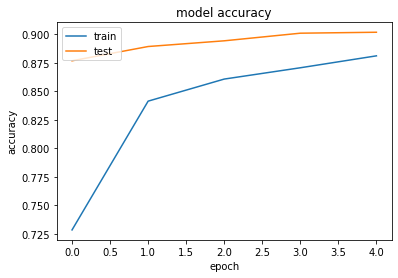

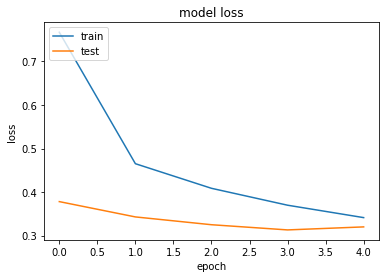

In [71]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [72]:
batch_size = 8
epochs = 5

input_tensor = Input(shape=(img_height,img_width,3))

base_model = InceptionV3(weights='imagenet',
                          include_top=False,
                          input_shape=(img_width, img_height, 3),
                          pooling='avg')

top_model = Sequential()
    
top_model.add(Dense(256, activation='relu', input_shape=base_model.output_shape[1:]))
top_model.add(Dropout(0.5))

top_model.add(Dense(128, activation='relu'))
top_model.add(Dropout(0.5))    

top_model.add(Dense(6, activation='softmax'))

top_model.load_weights('top-weights-inception3.hdf5')

model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

model.compile(optimizer=SGD(lr=0.005, momentum=0.1, nesterov=True),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


checkpointer = ModelCheckpoint(filepath='top-weights-inception3.hdf5', verbose=1, save_best_only=True)

train_datagen = image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')

history = model.fit_generator(train_generator,
                            steps_per_epoch=nb_train_samples // batch_size,
                            epochs=epochs,
                            validation_data=validation_generator,
                            validation_steps=nb_validation_samples // batch_size)

Found 12832 images belonging to 6 classes.
Found 1200 images belonging to 6 classes.
Epoch 1/5
1604/1604 [==============================] - 242s 151ms/step - loss: 0.6802 - accuracy: 0.7676 - val_loss: 0.1654 - val_accuracy: 0.8883
Epoch 2/5
1604/1604 [==============================] - 224s 140ms/step - loss: 0.5076 - accuracy: 0.8322 - val_loss: 0.0945 - val_accuracy: 0.9092
Epoch 3/5
1604/1604 [==============================] - 224s 140ms/step - loss: 0.4274 - accuracy: 0.8567 - val_loss: 0.0622 - val_accuracy: 0.9075
Epoch 4/5
1604/1604 [==============================] - 225s 140ms/step - loss: 0.3919 - accuracy: 0.8718 - val_loss: 0.0380 - val_accuracy: 0.9125
Epoch 5/5
1604/1604 [==============================] - 226s 141ms/step - loss: 0.3444 - accuracy: 0.8863 - val_loss: 0.0376 - val_accuracy: 0.9192


In [73]:
test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

score = model.evaluate_generator(test_generator, batch_size)

print("Loss: ", score[0], "Accuracy: ", score[1])
accur.append(score[1])

Found 3000 images belonging to 6 classes.
Loss:  0.051974814385175705 Accuracy:  0.890625


In [ ]:
start_time = time.time()
model.predict(IMGS)
spd.append(400 / (time.time() - start_time))
print("--- %s seconds ---" % (time.time() - start_time))
labels.append('InceptionV3')

In [74]:
from keras.applications import MobileNetV2

In [75]:
input_tensor = Input(shape=(img_height,img_width,3))

base_model = MobileNetV2(weights='imagenet',
                          include_top=False,
                          input_shape=(img_width, img_height, 3),
                          pooling='avg')

data_generator = image.ImageDataGenerator(rescale=1. / 255)

train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

bottleneck_features_train = base_model.predict_generator(
        train_generator, 
        nb_train_samples // batch_size)

print('Prediction of the training set finished.')

np.save(open('bottleneck_features_train_mobileNet.npy', 'wb'),
            bottleneck_features_train)

validation_generator = data_generator.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

bottleneck_features_validation = base_model.predict_generator(
        validation_generator, 
        nb_validation_samples // batch_size)

print('Prediction of the validation set finished.')

np.save(open('bottleneck_features_validation_mobileNet.npy', 'wb'),
            bottleneck_features_validation)

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Found 12832 images belonging to 6 classes.
Prediction of the training set finished.
Found 1200 images belonging to 6 classes.
Prediction of the validation set finished.


In [76]:
train_data = np.load(open('bottleneck_features_train_mobileNet.npy', 'rb'))
validation_data = np.load(open('bottleneck_features_validation_mobileNet.npy', 'rb'))

In [77]:
model = Sequential()
    
model.add(Dense(256, activation='relu', input_shape=base_model.output_shape[1:]))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))    

model.add(Dense(6, activation='softmax'))

model.compile(optimizer=SGD(lr=0.005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='top-weights-mobileNet.hdf5', verbose=1, save_best_only=True)

history = model.fit(train_data,
                    train_labels,
                    epochs=10,
                    batch_size=batch_size,
                    callbacks=[checkpointer],
                    validation_data=(validation_data, validation_labels))

Train on 12832 samples, validate on 1200 samples
Epoch 1/10
12832/12832 [==============================] - 5s 357us/step - loss: 0.6898 - accuracy: 0.7474 - val_loss: 0.3241 - val_accuracy: 0.8858

Epoch 00001: val_loss improved from inf to 0.32407, saving model to top-weights-mobileNet.hdf5
Epoch 2/10
12832/12832 [==============================] - 5s 369us/step - loss: 0.4179 - accuracy: 0.8517 - val_loss: 0.3008 - val_accuracy: 0.8942

Epoch 00002: val_loss improved from 0.32407 to 0.30083, saving model to top-weights-mobileNet.hdf5
Epoch 3/10
12832/12832 [==============================] - 5s 376us/step - loss: 0.3653 - accuracy: 0.8730 - val_loss: 0.2868 - val_accuracy: 0.9050

Epoch 00003: val_loss improved from 0.30083 to 0.28683, saving model to top-weights-mobileNet.hdf5
Epoch 4/10
12832/12832 [==============================] - 5s 365us/step - loss: 0.3360 - accuracy: 0.8806 - val_loss: 0.2794 - val_accuracy: 0.9033

Epoch 00004: val_loss improved from 0.28683 to 0.27941, saving

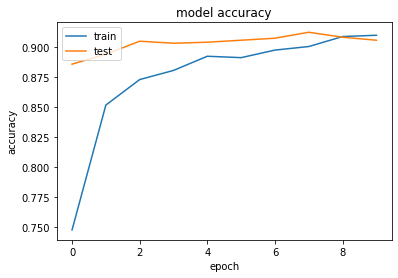

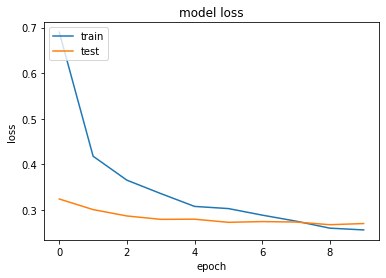

In [78]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [79]:
batch_size = 8
epochs = 5

input_tensor = Input(shape=(img_height,img_width,3))

base_model = MobileNetV2(weights='imagenet',
                          include_top=False,
                          input_shape=(img_width, img_height, 3),
                          pooling='avg')

top_model = Sequential()
    
top_model.add(Dense(256, activation='relu', input_shape=base_model.output_shape[1:]))
top_model.add(Dropout(0.5))

top_model.add(Dense(128, activation='relu'))
top_model.add(Dropout(0.5))    

top_model.add(Dense(6, activation='softmax'))

top_model.load_weights('top-weights-mobileNet.hdf5')

model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

model.compile(optimizer=SGD(lr=0.005, momentum=0.1, nesterov=True),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


checkpointer = ModelCheckpoint(filepath='top-weights-mobileNet.hdf5', verbose=1, save_best_only=True)

train_datagen = image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')

history = model.fit_generator(train_generator,
                            steps_per_epoch=nb_train_samples // batch_size,
                            epochs=epochs,
                            validation_data=validation_generator,
                            validation_steps=nb_validation_samples // batch_size)

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Found 12832 images belonging to 6 classes.
Found 1200 images belonging to 6 classes.
Epoch 1/5
1604/1604 [==============================] - 192s 120ms/step - loss: 0.6517 - accuracy: 0.7765 - val_loss: 0.2473 - val_accuracy: 0.8167
Epoch 2/5
1604/1604 [==============================] - 179s 112ms/step - loss: 0.4679 - accuracy: 0.8473 - val_loss: 0.4934 - val_accuracy: 0.8300
Epoch 3/5
1604/1604 [==============================] - 180s 112ms/step - loss: 0.3847 - accuracy: 0.8731 - val_loss: 0.2756 - val_accuracy: 0.8408
Epoch 4/5
1604/1604 [==============================] - 179s 112ms/step - loss: 0.3483 - accuracy: 0.8899 - val_loss: 0.1258 - val_accuracy: 0.8833
Epoch 5/5
1604/1604 [==============================] - 179s 111ms/step - loss: 0.3182 - accuracy: 0.8989 - val_loss: 0.2407 - val_accuracy: 0.8908


In [80]:
test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

score = model.evaluate_generator(test_generator, batch_size)

print("Loss: ", score[0], "Accuracy: ", score[1])
accur.append(score[1])

Found 3000 images belonging to 6 classes.
Loss:  0.010270381346344948 Accuracy:  0.890625


In [ ]:
start_time = time.time()
model.predict(IMGS)
spd.append(400 / (time.time() - start_time))
print("--- %s seconds ---" % (time.time() - start_time))
labels.append('MobileNet')

In [81]:
from keras.applications import VGG16

In [82]:
input_tensor = Input(shape=(img_height,img_width,3))

base_model = VGG16(weights='imagenet',
                          include_top=False,
                          input_shape=(img_width, img_height, 3),
                          pooling='avg')

data_generator = image.ImageDataGenerator(rescale=1. / 255)

train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

bottleneck_features_train = base_model.predict_generator(
        train_generator, 
        nb_train_samples // batch_size)

print('Prediction of the training set finished.')

np.save(open('bottleneck_features_train_vgg16.npy', 'wb'),
            bottleneck_features_train)

validation_generator = data_generator.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

bottleneck_features_validation = base_model.predict_generator(
        validation_generator, 
        nb_validation_samples // batch_size)

print('Prediction of the validation set finished.')

np.save(open('bottleneck_features_validation_vgg16.npy', 'wb'),
            bottleneck_features_validation)

Found 12832 images belonging to 6 classes.
Prediction of the training set finished.
Found 1200 images belonging to 6 classes.
Prediction of the validation set finished.


In [83]:
train_data = np.load(open('bottleneck_features_train_vgg16.npy', 'rb'))
validation_data = np.load(open('bottleneck_features_validation_vgg16.npy', 'rb'))

In [84]:
model = Sequential()
    
model.add(Dense(256, activation='relu', input_shape=base_model.output_shape[1:]))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))    

model.add(Dense(6, activation='softmax'))

model.compile(optimizer=SGD(lr=0.005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='top-weights-vgg16.hdf5', verbose=1, save_best_only=True)

history = model.fit(train_data,
                    train_labels,
                    epochs=10,
                    batch_size=batch_size,
                    callbacks=[checkpointer],
                    validation_data=(validation_data, validation_labels))

Train on 12832 samples, validate on 1200 samples
Epoch 1/10
12832/12832 [==============================] - 5s 358us/step - loss: 1.2335 - accuracy: 0.4809 - val_loss: 0.7311 - val_accuracy: 0.7625

Epoch 00001: val_loss improved from inf to 0.73112, saving model to top-weights-vgg16.hdf5
Epoch 2/10
12832/12832 [==============================] - 4s 344us/step - loss: 0.8118 - accuracy: 0.6658 - val_loss: 0.6178 - val_accuracy: 0.7725

Epoch 00002: val_loss improved from 0.73112 to 0.61779, saving model to top-weights-vgg16.hdf5
Epoch 3/10
12832/12832 [==============================] - 4s 350us/step - loss: 0.6970 - accuracy: 0.7253 - val_loss: 0.5411 - val_accuracy: 0.8217

Epoch 00003: val_loss improved from 0.61779 to 0.54114, saving model to top-weights-vgg16.hdf5
Epoch 4/10
12832/12832 [==============================] - 4s 346us/step - loss: 0.6276 - accuracy: 0.7574 - val_loss: 0.4916 - val_accuracy: 0.8333

Epoch 00004: val_loss improved from 0.54114 to 0.49161, saving model to to

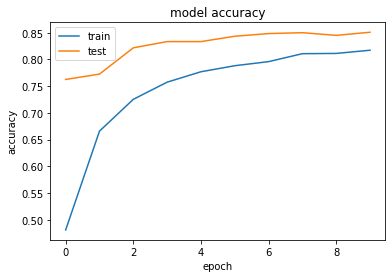

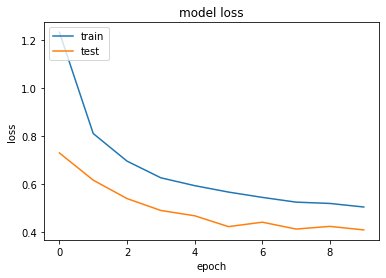

In [85]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [86]:
batch_size = 8
epochs = 5

input_tensor = Input(shape=(img_height,img_width,3))

base_model = VGG16(weights='imagenet',
                          include_top=False,
                          input_shape=(img_width, img_height, 3),
                          pooling='avg')

top_model = Sequential()
    
top_model.add(Dense(256, activation='relu', input_shape=base_model.output_shape[1:]))
top_model.add(Dropout(0.5))

top_model.add(Dense(128, activation='relu'))
top_model.add(Dropout(0.5))    

top_model.add(Dense(6, activation='softmax'))

top_model.load_weights('top-weights-vgg16.hdf5')

model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

model.compile(optimizer=SGD(lr=0.005, momentum=0.1, nesterov=True),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


checkpointer = ModelCheckpoint(filepath='top-weights-vgg16.hdf5', verbose=1, save_best_only=True)

train_datagen = image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')

history = model.fit_generator(train_generator,
                            steps_per_epoch=nb_train_samples // batch_size,
                            epochs=epochs,
                            validation_data=validation_generator,
                            validation_steps=nb_validation_samples // batch_size)

Found 12832 images belonging to 6 classes.
Found 1200 images belonging to 6 classes.
Epoch 1/5
1604/1604 [==============================] - 152s 95ms/step - loss: 0.8060 - accuracy: 0.7036 - val_loss: 0.5144 - val_accuracy: 0.8367
Epoch 2/5
1604/1604 [==============================] - 151s 94ms/step - loss: 0.4307 - accuracy: 0.8550 - val_loss: 0.0034 - val_accuracy: 0.9208
Epoch 3/5
1604/1604 [==============================] - 150s 93ms/step - loss: 0.3330 - accuracy: 0.8911 - val_loss: 0.0228 - val_accuracy: 0.8983
Epoch 4/5
1604/1604 [==============================] - 150s 94ms/step - loss: 0.2866 - accuracy: 0.9054 - val_loss: 0.2207 - val_accuracy: 0.8925
Epoch 5/5
1604/1604 [==============================] - 150s 94ms/step - loss: 0.2540 - accuracy: 0.9177 - val_loss: 0.0870 - val_accuracy: 0.9058


In [87]:
test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

score = model.evaluate_generator(test_generator, batch_size)

print("Loss: ", score[0], "Accuracy: ", score[1])
accur.append(score[1])

Found 3000 images belonging to 6 classes.
Loss:  0.10495084524154663 Accuracy:  0.875


In [ ]:
start_time = time.time()
model.predict(IMGS)
spd.append(400 / (time.time() - start_time))
print("--- %s seconds ---" % (time.time() - start_time))
labels.append('VGG16')

In [88]:
from keras.applications import ResNet50

In [89]:
input_tensor = Input(shape=(img_height,img_width,3))

base_model = ResNet50(weights='imagenet',
                          include_top=False,
                          input_shape=(img_width, img_height, 3),
                          pooling='avg')

data_generator = image.ImageDataGenerator(rescale=1. / 255)

train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

bottleneck_features_train = base_model.predict_generator(
        train_generator, 
        nb_train_samples // batch_size)

print('Prediction of the training set finished.')

np.save(open('bottleneck_features_train_resNet.npy', 'wb'),
            bottleneck_features_train)

validation_generator = data_generator.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

bottleneck_features_validation = base_model.predict_generator(
        validation_generator, 
        nb_validation_samples // batch_size)

print('Prediction of the validation set finished.')

np.save(open('bottleneck_features_validation_resNet.npy', 'wb'),
            bottleneck_features_validation)

Found 12832 images belonging to 6 classes.
Prediction of the training set finished.
Found 1200 images belonging to 6 classes.
Prediction of the validation set finished.


In [90]:
train_data = np.load(open('bottleneck_features_train_resNet.npy', 'rb'))
validation_data = np.load(open('bottleneck_features_validation_resNet.npy', 'rb'))

In [91]:
model = Sequential()
    
model.add(Dense(256, activation='relu', input_shape=base_model.output_shape[1:]))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))    

model.add(Dense(6, activation='softmax'))

model.compile(optimizer=SGD(lr=0.005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='top-weights-resNet.hdf5', verbose=1, save_best_only=True)

history = model.fit(train_data,
                    train_labels,
                    epochs=10,
                    batch_size=batch_size,
                    callbacks=[checkpointer],
                    validation_data=(validation_data, validation_labels))

Train on 12832 samples, validate on 1200 samples
Epoch 1/10
12832/12832 [==============================] - 5s 357us/step - loss: 1.7992 - accuracy: 0.1767 - val_loss: 1.7892 - val_accuracy: 0.1675

Epoch 00001: val_loss improved from inf to 1.78923, saving model to top-weights-resNet.hdf5
Epoch 2/10
12832/12832 [==============================] - 4s 335us/step - loss: 1.7832 - accuracy: 0.2050 - val_loss: 1.7599 - val_accuracy: 0.2525

Epoch 00002: val_loss improved from 1.78923 to 1.75989, saving model to top-weights-resNet.hdf5
Epoch 3/10
12832/12832 [==============================] - 4s 341us/step - loss: 1.7476 - accuracy: 0.2398 - val_loss: 1.7032 - val_accuracy: 0.2683

Epoch 00003: val_loss improved from 1.75989 to 1.70320, saving model to top-weights-resNet.hdf5
Epoch 4/10
12832/12832 [==============================] - 4s 347us/step - loss: 1.7193 - accuracy: 0.2418 - val_loss: 1.6880 - val_accuracy: 0.2708

Epoch 00004: val_loss improved from 1.70320 to 1.68803, saving model to

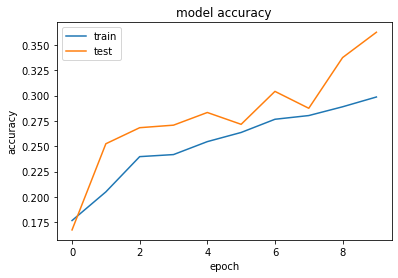

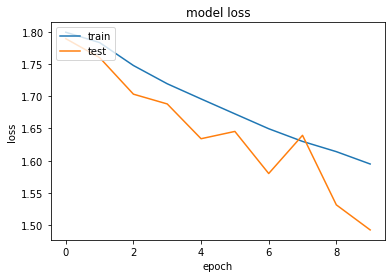

In [92]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [93]:
batch_size = 8
epochs = 5

input_tensor = Input(shape=(img_height,img_width,3))

base_model = ResNet50(weights='imagenet',
                          include_top=False,
                          input_shape=(img_width, img_height, 3),
                          pooling='avg')

top_model = Sequential()
    
top_model.add(Dense(256, activation='relu', input_shape=base_model.output_shape[1:]))
top_model.add(Dropout(0.5))

top_model.add(Dense(128, activation='relu'))
top_model.add(Dropout(0.5))    

top_model.add(Dense(6, activation='softmax'))

top_model.load_weights('top-weights-resNet.hdf5')

model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

model.compile(optimizer=SGD(lr=0.005, momentum=0.1, nesterov=True),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


checkpointer = ModelCheckpoint(filepath='top-weights-resNet.hdf5', verbose=1, save_best_only=True)

train_datagen = image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')

history = model.fit_generator(train_generator,
                            steps_per_epoch=nb_train_samples // batch_size,
                            epochs=epochs,
                            validation_data=validation_generator,
                            validation_steps=nb_validation_samples // batch_size)

Found 12832 images belonging to 6 classes.
Found 1200 images belonging to 6 classes.
Epoch 1/5
1604/1604 [==============================] - 234s 146ms/step - loss: 0.6980 - accuracy: 0.7512 - val_loss: 0.0543 - val_accuracy: 0.8775
Epoch 2/5
1604/1604 [==============================] - 220s 137ms/step - loss: 0.4120 - accuracy: 0.8636 - val_loss: 0.1246 - val_accuracy: 0.9067
Epoch 3/5
1604/1604 [==============================] - 220s 137ms/step - loss: 0.3370 - accuracy: 0.8897 - val_loss: 0.0055 - val_accuracy: 0.9267
Epoch 4/5
1604/1604 [==============================] - 220s 137ms/step - loss: 0.2846 - accuracy: 0.9066 - val_loss: 0.3917 - val_accuracy: 0.8850
Epoch 5/5
1604/1604 [==============================] - 220s 137ms/step - loss: 0.2456 - accuracy: 0.9197 - val_loss: 0.0079 - val_accuracy: 0.9208


In [94]:
test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

score = model.evaluate_generator(test_generator, batch_size)

print("Loss: ", score[0], "Accuracy: ", score[1])
accur.append(score[1])

Found 3000 images belonging to 6 classes.
Loss:  0.009955594316124916 Accuracy:  0.90625


In [ ]:
start_time = time.time()
model.predict(IMGS)
spd.append(400 / (time.time() - start_time))
print("--- %s seconds ---" % (time.time() - start_time))
labels.append('ResNet50')

In [97]:
Были выбраны несколько популярных архитектур свёрточных нейронных сетей для классификации изображений: denseNet121, inceptionV3, mobileNetV2, ResNet50, VGG16, xception. 
Предпочтение было отдано именно нейросетевым подходам, так как для оптимизации работы в Computer Vision желательно, 
как можно больше процессор выполнялось через GPU, к тому же состязательные сети и сети для работы с изображениями на данный момент дают результат заметно лучше человека.
Для сравнения былы применена аугументация к датасету. Можно заметить, насколько она улучшает точность классификации нежели просто обучить модель на чистых изображениях.
Были использованы реализации данных моделей их пакета Keras с предобученными весами на 'imagenet'.
А так же применён подход transfer learning. Из архитектур были убраны последний полносвязные слои. Далее через модели были пропущены изображения из train датасета и сохранены полученные признаки.
Затем добавлена небольшая полносвязная сеть с соответствием размеров для входов и выходов для конкретной модели и количества классов в данных и обучена на полученных до этого признаках.
После модель уже была обучена на датасете с аугументацией данных, в результате чего конечная точность заметно улучшилась.

SyntaxError: ignored

In [107]:
import matplotlib

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, accur, width, label='accur')
rects2 = ax.bar(x + width/2, women_means, width, label='spd')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('SPD/ACC Comparsion by Model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()